<a href="https://colab.research.google.com/github/EstebanAG1005/Lab-9-DL/blob/main/lab9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Task - Práctica

Se le proporcionan 5 años de datos de ventas de artículos de una cadena de tiendas y se le pide que prediga 3 meses de ventas para 50 artículos diferentes en 10 tiendas diferentes. Descarguen el dataset de Kaggle aquí por favor. Para esto considere los siguiente:

### 1 - Preparación de datos

In [3]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split

a. Limpieza de datos: En este paso, inspecciona los datos en busca de valores nulos o inconsistentes. Pandas es una gran biblioteca para manejar esto en Python.

In [4]:
from google.colab import drive
drive.mount('/content/drive')

data_path = "/content/drive/MyDrive/train.csv"

data = pd.read_csv(data_path)

# Verificando valores nulos
print(data.isnull().sum())

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
date     0
store    0
item     0
sales    0
dtype: int64


b. Transformación de datos: Convierte fechas en tipo de dato datetime y escala las ventas, ya que los modelos de redes neuronales funcionan mejor con valores escalados.

In [5]:
# Convertir la columna 'date' a datetime
data['date'] = pd.to_datetime(data['date'])

# Escalado de la columna 'sales'
scaler = MinMaxScaler(feature_range=(0, 1))
data['sales'] = scaler.fit_transform(data[['sales']])

### 2 - Preprocesamiento de datos

a. División de series temporales:

In [6]:
# Asumiendo que 'data' es tu DataFrame y ya has realizado la limpieza y escalado
train_data = data[data['date'] < '2017-01-01']
test_data = data[data['date'] >= '2017-01-01']

# Debes asegurarte de que solo estés trabajando con la columna que deseas predecir, en este caso, 'sales'
train_data = train_data[['sales']].values
test_data = test_data[['sales']].values


b. Generación de secuencias: Este paso involucra la creación de secuencias de datos históricos para usar como entrada para el modelo.

In [7]:
def create_sequences(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:(i + window_size), 0])
        y.append(data[i + window_size, 0])
    return np.array(X), np.array(y)

In [8]:
# Definir el tamaño de la ventana
window_size = 60  # Por ejemplo, usar los 60 puntos de datos anteriores para predecir el siguiente

# Crear secuencias para entrenamiento
X_train, y_train = create_sequences(train_data, window_size)

# Crear secuencias para prueba
X_test, y_test = create_sequences(test_data, window_size)

# Es importante que los datos estén en la forma correcta para alimentar a la LSTM
# Reshape [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Dividir los datos de entrenamiento para crear un conjunto de validación
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, shuffle=False)


### 3 - Selección de modelo


Optaremos por una red LSTM

### 4 - Arquitectura del modelo

In [9]:
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1)) # Salida de una unidad para la predicción de ventas

model.compile(optimizer='adam', loss='mean_squared_error')


### 5 - Entrenamiento del modelo

In [10]:
# Entrenar el modelo
model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val))

Epoch 1/50
18261/18261 [==============================] - 166s 9ms/step - loss: 0.0018 - val_loss: 0.0011
Epoch 2/50
18261/18261 [==============================] - 155s 8ms/step - loss: 0.0015 - val_loss: 0.0011
Epoch 3/50
18261/18261 [==============================] - 155s 8ms/step - loss: 0.0014 - val_loss: 0.0010
Epoch 4/50
18261/18261 [==============================] - 160s 9ms/step - loss: 0.0014 - val_loss: 0.0010
Epoch 5/50
18261/18261 [==============================] - 159s 9ms/step - loss: 0.0014 - val_loss: 0.0010
Epoch 6/50
18261/18261 [==============================] - 154s 8ms/step - loss: 0.0013 - val_loss: 0.0010
Epoch 7/50
18261/18261 [==============================] - 159s 9ms/step - loss: 0.0013 - val_loss: 0.0010
Epoch 8/50
18261/18261 [==============================] - 155s 8ms/step - loss: 0.0013 - val_loss: 9.8201e-04
Epoch 9/50
18261/18261 [==============================] - 155s 9ms/step - loss: 0.0013 - val_loss: 9.8914e-04
Epoch 10/50
18261/18261 [=============

In [17]:
# Guardar el modelo
model.save('my_model.keras')

### 6 - Evaluación del modelo

In [18]:
from tensorflow.keras.models import load_model

# Cargar el modelo
new_model = load_model('my_model.keras')

In [20]:
# Evaluar el modelo con datos de prueba
loss = new_model.evaluate(X_test, y_test)
print(f"Loss: {loss}")

5702/5702 [==============================] - 25s 4ms/step - loss: 0.0014
Loss: 0.001416865736246109


In [21]:
# Si deseas hacer predicciones y compararlas con los valores reales
predicted_sales = new_model.predict(X_test)

5702/5702 [==============================] - 21s 4ms/step


In [22]:
# 'predicted_sales' son los valores escalados, por lo que podrías querer revertir la transformación
predicted_sales = scaler.inverse_transform(predicted_sales)

In [23]:
# Suponiendo que 'actual_sales' es la parte de 'y_test' que corresponde a las ventas reales
actual_sales = scaler.inverse_transform(y_test.reshape(-1, 1))

Mean Squared Error (MSE): 75.60532708257468
Mean Absolute Error (MAE): 6.623481505404855


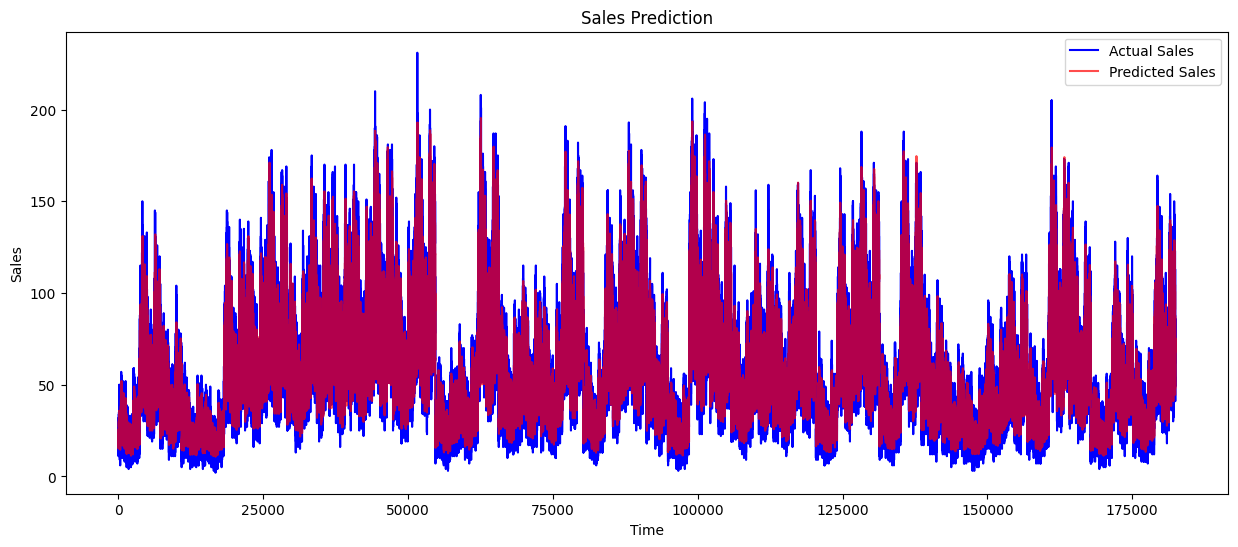

In [24]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

# Calcular y imprimir MSE y MAE
mse = mean_squared_error(actual_sales, predicted_sales)
mae = mean_absolute_error(actual_sales, predicted_sales)

print(f"Mean Squared Error (MSE): {mse}")
print(f"Mean Absolute Error (MAE): {mae}")

# Visualizar los resultados
plt.figure(figsize=(15,6))

# Dibujar las ventas reales
plt.plot(actual_sales, color='blue', label='Actual Sales')

# Dibujar las ventas predichas
plt.plot(predicted_sales, color='red', alpha=0.7, label='Predicted Sales')

plt.title('Sales Prediction')
plt.xlabel('Time')
plt.ylabel('Sales')
plt.legend()
plt.show()